In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm

C:\Users\USER\anaconda3\envs\badText10\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\USER\anaconda3\envs\badText10\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\USER\anaconda3\envs\badText10\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

C:\Users\USER\AppData\Roaming\Python\Python36\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


In [3]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [4]:
##GPU 사용 시
device = torch.device("cuda:0")

In [5]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

# Load Dataset

In [6]:
import gluonnlp as nlp

In [7]:
kobert_get_tokenizer = get_tokenizer()
kobert_model, kobert_vocab = get_pytorch_kobert_model()
kobert_tokenizer = nlp.data.BERTSPTokenizer(kobert_get_tokenizer, kobert_vocab, lower=False)

using cached model. C:\Users\USER\Desktop\2022_master\KoBERT\.cache\kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. C:\Users\USER\Desktop\2022_master\KoBERT\.cache\kobert_v1.zip
using cached model. C:\Users\USER\Desktop\2022_master\KoBERT\.cache\kobert_news_wiki_ko_cased-1087f8699e.spiece


In [8]:
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
koco_train_dataset = nlp.data.TSVDataset(data_path+"koco_hate_train.txt", num_discard_samples=1)
koco_test_dataset = nlp.data.TSVDataset(data_path+"koco_hate_test.txt", num_discard_samples=1)

In [9]:
def detokenizer(tokens):
    decode_tokens = list()
    for idx in tokens:
        token = kobert_vocab.idx_to_token[idx]
        if token == '[PAD]':
            break
        decode_tokens.append(token)
    return decode_tokens

In [10]:
transform = nlp.data.BERTSentenceTransform(
            kobert_tokenizer, max_seq_length=max_len, pad=True, pair=False)
token_list = [transform([i[0]]) for i in koco_test_dataset]

In [11]:
idx = 70
detoken_list = detokenizer(token_list[idx][0])
print(koco_test_dataset[idx][0])
print(detoken_list)

짠돌이보단 낫다
['[CLS]', '▁', '짠', '돌', '이', '보', '단', '▁', '낫', '다', '[SEP]']


In [12]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [13]:
koco_train_BERTDataset = BERTDataset(koco_train_dataset, 0, 1, kobert_tokenizer, max_len, True, False)
koco_test_BERTDataset = BERTDataset(koco_test_dataset, 0, 1, kobert_tokenizer, max_len, True, False)

In [14]:
koco_train_BERTDataset.__getitem__(1)

(array([   2,  517,   54,  517,   54,  517,   54,  517,   54, 4958, 7206,
        2149, 7119, 7095, 1678, 2468,  517,   54,  517,   54,  517,   54,
        1458, 5655,  517, 5450, 5439, 6797, 6117, 5785, 6213, 6699,  517,
          54,  517,   54,  517,   54, 1185, 6213, 6699, 5916, 7095, 2948,
        7766, 7088, 2149, 7416, 3166, 7318, 6224, 7864, 5703,    0,    3,
           1,    1,    1,    1,    1,    1,    1,    1,    1]),
 array(55),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0)

In [15]:
koco_train_dataloader = torch.utils.data.DataLoader(koco_train_BERTDataset, batch_size=batch_size, num_workers=0)
koco_test_dataloader = torch.utils.data.DataLoader(koco_test_BERTDataset, batch_size=batch_size, num_workers=0)

# Model

In [16]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [17]:
model = BERTClassifier(kobert_model,  dr_rate=0.5).to(device)

In [18]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [19]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [20]:
t_total = len(koco_train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [21]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [22]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# Train Model

In [23]:
import time
start_time = time.time()

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(koco_train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label) #cross_entropy loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
        
        del loss, label, token_ids, valid_length, segment_ids, out
        torch.cuda.empty_cache()
       
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
end_time = time.time()
print("train_run_time: ", float(end_time) - float(start_time))

  0%|          | 0/124 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.1539857387542725 train acc 0.1875
epoch 1 train acc 0.4440524193548387


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9480105042457581 train acc 0.5
epoch 2 train acc 0.5767389112903226


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7797214984893799 train acc 0.65625
epoch 3 train acc 0.6788474462365591


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.5610581040382385 train acc 0.75
epoch 4 train acc 0.7589465725806451


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.37405136227607727 train acc 0.8125
epoch 5 train acc 0.8131300403225806


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.6775139570236206 train acc 0.75
epoch 6 train acc 0.8736139112903226


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.2687787711620331 train acc 0.890625
epoch 7 train acc 0.9332157258064516


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.19055968523025513 train acc 0.921875
epoch 8 train acc 0.9523689516129032


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.09088266640901566 train acc 0.953125
epoch 9 train acc 0.9732862903225806


  0%|          | 0/124 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.020452937111258507 train acc 1.0
epoch 10 train acc 0.9819808467741935
train_run_time:  272.11071705818176


In [25]:
torch.save(model.state_dict(), 'koco_kobert_model.pt')

# Test Model

In [27]:
preds_torch_list=[] #predict 값 list 생성
test_acc=0
#model_path = 'C:/Users/USER/Desktop/2022/koco_kobert_model.pt'
#model_path = 'koco_kobert_model.pt'
#model.load_state_dict(torch.load(model_path))
model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(koco_test_dataloader)):
    with torch.no_grad():
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        preds_torch_list.append(out)
        
        del label, token_ids, valid_length, segment_ids, out
        torch.cuda.empty_cache()

  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
preds_list = list()
for temp_list in preds_torch_list:
    max_vals, max_indices = torch.max(torch.tensor(temp_list), axis=1)
    max_list = max_indices.tolist()
    preds_list.extend(max_list)

C:\Users\USER\anaconda3\envs\badText10\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


# Confusion Matrix

In [29]:
y_test = koco_test_BERTDataset.labels
preds_list = preds_list

              precision    recall  f1-score   support

           0       0.61      0.82      0.70       160
           1       0.53      0.49      0.51       189
           2       0.73      0.48      0.58       122

    accuracy                           0.60       471
   macro avg       0.62      0.60      0.59       471
weighted avg       0.61      0.60      0.59       471



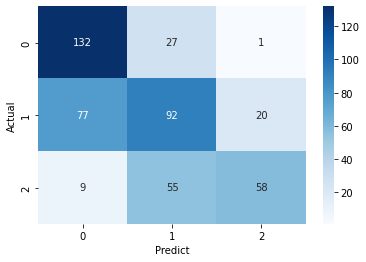

In [30]:
## classification_report
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [31]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [32]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.4225)
tensor(0.4650)
